# A more realistic linear regression example: Predicting bicycle traffic

# Disclaimer
This example is from https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html and was adapted by Emma Pabich for CSME2 WS20/21. Additional modifications in WS21/22.

Last edit: 30/11/21

## Preliminaries

Import all necessary libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import datetime

## Example: Predicting Bicycle Traffic
As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

In this section, we will join the data about bicycle traffic in Seattle with other data. We will then use linear regression to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor. 

The NOAA makes available their daily weather station data and Seattle tracks bicycle traffic on the Fremont bridge since 2012. Both datasets are available for download.

If you want, have a look at the datasets here: https://data.seattle.gov/Transportation/Fremont-Bridge-Bicycle-Counter/65db-xm6k 
and here: https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND.

## Bicycle traffic data

Import Bicycle traffic data from the Fremont bridge.

In [2]:
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
print(f"Number of samples: {counts.shape[0]}")
counts.head(3)

Number of samples: 137078


,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0


Compute total daily bicycle traffic

In [3]:
daily = counts.resample('d').sum() #add up traffic for each day
daily['Total'] = daily['Fremont Bridge Total'] #add new column with total counts
daily = daily[['Total']] # remove other colums
daily.head()

,Total
Date,
2012-10-03,7042.0
2012-10-04,6950.0
2012-10-05,6296.0
2012-10-06,4012.0
2012-10-07,4284.0


## Adding useful information to our dataset

Add information about the day of the week and holidays. For this add 7 binary colums which indicate the day of the week and 1 binary column indicating a national holiday.

In [4]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

Now add information about the hours of daylight (because we suspect that this affects how many people ride their bike).

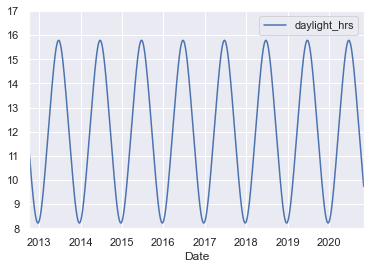

In [5]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - datetime.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
_ = plt.ylim(8, 17)

Import weather data and enhance our data set with the average temperature, total precipitation and a flag that indicates whether a day is dry (has zero precipitation).

In [6]:
weather = pd.read_csv('BicycleWeather_large.csv', index_col='DATE', parse_dates=True)
weather.head()

,"STATION,NAME""",PRCP,TAVG,TMAX,TMIN
DATE,,,,,
2012-01-01,"USW00024233,SEATTLE TACOMA AIRPORT WA US""",0.00,NaN,55,41
2012-01-02,"USW00024233,SEATTLE TACOMA AIRPORT WA US""",0.43,NaN,51,37
2012-01-03,"USW00024233,SEATTLE TACOMA AIRPORT WA US""",0.03,NaN,53,45
2012-01-04,"USW00024233,SEATTLE TACOMA AIRPORT WA US""",0.80,NaN,54,42
2012-01-05,"USW00024233,SEATTLE TACOMA AIRPORT WA US""",0.05,NaN,48,37


### Data preparation
It's very common in data science, statistics etc that a data set needs to be transformed (cleaned up, tidied up etc).

In [7]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

Finally, let's add a counter that increases from day 1, and measures how many years have passed. This will let us measure any observed annual increase or decrease in daily crossings:

In [8]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1,0.010959


Now, before we start we drop any invalid data, meaning we drop any rows with null values.

In [9]:
daily.dropna(axis=0, how='any', inplace=True) # axis=0 to drop rows not columns
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1,0.010959


## Train/Validation/Test Split
Split dataset into three subsets.

In [10]:
N = len(daily)
perm = np.random.RandomState(42).permutation(daily.index)  # Shuffle indices, use a fixed random seed for reproducibility

daily_train = daily.loc[perm[:int(0.6*N)]]  # 60% for train set
daily_test = daily.loc[perm[int(0.6*N):int(0.8*N)]]   # 20% for test set
daily_val = daily.loc[perm[int(0.8*N):]]  # 20% for validation set

print(f'shape of train set: {daily_train.shape}')
print(f'shape of validation set: {daily_val.shape}')
print(f'shape of test set: {daily_test.shape}')

shape of train set: (1770, 14)
shape of validation set: (591, 14)
shape of test set: (590, 14)


## Fit simple linear regression model

We now build our input and output vector for the training.

In [11]:
from sklearn.linear_model import LinearRegression

input_column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual'] #everything but the total bicycle traffic

x_1d_train = daily_train[['daylight_hrs']].values # information about daylight hours
x_nd_train = daily_train[input_column_names].values #everything but the total bicycle traffic
y_train = daily_train['Total'].values #total bicycle traffic

print('dimensions of one dimensional input x_1d: ', np.shape(x_1d_train))
print('dimensions of multi dimensional input x_nd: ', np.shape(x_nd_train))
print('dimensions of y: ', np.shape(y_train))

dimensions of one dimensional input x_1d:  (1770, 1)
dimensions of multi dimensional input x_nd:  (1770, 13)
dimensions of y:  (1770,)


Then fit a linear regression model using scikit-learn linear regression function.
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

This functions assumes ``y_pred = model.intercept_ + model.coef_ * x``

In [12]:
model_1d = LinearRegression(fit_intercept=True) # model will be our function
model_nd = LinearRegression(fit_intercept=True) # model will be our function
model_1d.fit(x_1d_train, y_train)
model_nd.fit(x_nd_train, y_train) # this approximates our function

x_1d_val = daily_val[['daylight_hrs']].values
x_nd_val = daily_val[input_column_names].values
y_val = daily_val['Total'].values #total bicycle traffic

daily_val['predicted_1d'] = model_1d.predict(x_1d_val)
daily_val['predicted_nd'] = model_nd.predict(x_nd_val) # call model with x as input

Finally, we can compare the total and predicted bicycle traffic visually:

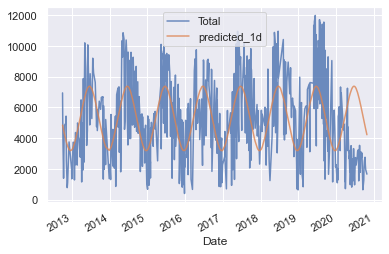

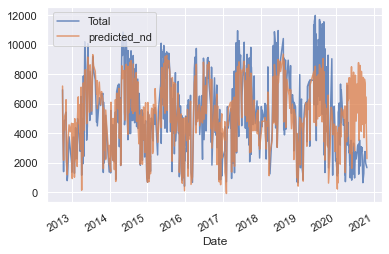

In [13]:
daily_val[['Total', 'predicted_1d']].plot(alpha=0.8)
daily_val[['Total', 'predicted_nd']].plot(alpha=0.8);

It is evident that we have missed some key features, especially during the summer time. Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures). Nevertheless, our rough approximation is enough to give us some insights.

### Assessing the model fit

To assess the quality of the model quantitatively, we can use the $R^2$ score (beyond CSME2).
$$
R^2 = 1 - \frac{\sum_i (y_{true}^i - y_{pred}^i)^2}{\sum_i (y_{true}^i - \bar{y}_{true})^2}
$$
The best possible score is 1.

With this we can compare the models:

In [14]:
print(f'R^2 one dimensional input:   {model_1d.score(x_1d_val, y_val):.2f}')
print(f'R^2 multi dimensional input: {model_nd.score(x_nd_val, y_val):.2f}')

R^2 one dimensional input:   0.16
R^2 multi dimensional input: 0.59


This confirmes the intuition that the multi dimensional imput drastically improves the model quality.

## Fit linear regression model with nonlinear basis functions

First, apply a polynomial feature transformation on the input data.

`PolynomialFeatures` from scikit-learn computes all polynomial combinations up to the specified degree.
For example, if an input sample is two dimensional and of the form $(a, b)$, the degree-2 polynomial features are $(1, a, b, a^2, ab, b^2)$.

In [15]:
from sklearn.preprocessing import PolynomialFeatures

# Use second and third degree polynomials
poly2 = PolynomialFeatures(2)
poly3 = PolynomialFeatures(3)

# Apply transformation to inputs
x_poly2_train = poly2.fit_transform(x_nd_train)
x_poly2_val = poly2.transform(x_nd_val)
x_poly3_train = poly3.fit_transform(x_nd_train)
x_poly3_val = poly3.transform(x_nd_val)

print(f'dimensions of x_poly2_train: {x_poly2_train.shape}')
print(f'dimensions of x_poly3_train: {x_poly3_train.shape}')

dimensions of x_poly2_train: (1770, 105)
dimensions of x_poly3_train: (1770, 560)


The number of features grows rapidly with higher degrees.


Then we fit fit linear regression models to the transformed inputs. 
If you want to know more about what happens, have a look here:
- https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/linear_model/_base.py#L481
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsqr.html

In [16]:
model_poly2 = LinearRegression(fit_intercept=False)
model_poly2.fit(x_poly2_train, y_train)

model_poly3 = LinearRegression(fit_intercept=False)
model_poly3.fit(x_poly3_train, y_train);

Evaluate the models:

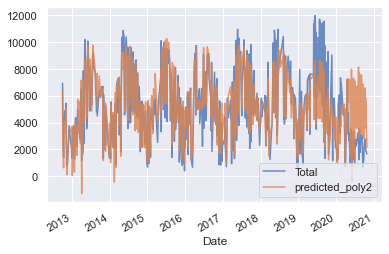

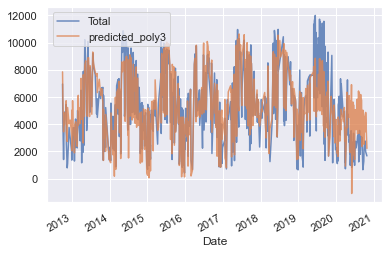

In [17]:
# Predict
daily_val['predicted_poly2'] = model_poly2.predict(x_poly2_val)     
daily_val['predicted_poly3'] = model_poly3.predict(x_poly3_val)     

# Plot
daily_val[['Total', 'predicted_poly2']].plot(alpha=0.8)
daily_val[['Total', 'predicted_poly3']].plot(alpha=0.8);

In [18]:
print(f'R^2 linear:                   {model_nd.score(x_nd_val, y_val):.3f}')
print(f'R^2 second degree polynomial: {model_poly2.score(x_poly2_val, y_val):.3f}')
print(f'R^2 third degree polynomial:  {model_poly3.score(x_poly3_val, y_val):.3f}')

R^2 linear:                   0.588
R^2 second degree polynomial: 0.659
R^2 third degree polynomial:  0.716


### Gaussian Basis Function
Instead of polynomial basis functions, we now use Gaussian Basis Functions.

In [19]:
def gauss_basis_function(x, means, variances):
    """Apply Gaussian basis function to each element."""
    return np.exp(-np.sum(((x[:, np.newaxis]-means)**2), axis=-1) / (2*variances))

First, we normalize the data.

In [20]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Normalize input data
scaler = StandardScaler()
x_nd_train_norm = scaler.fit_transform(x_nd_train)

# Normalize target
scaler_y = StandardScaler()
y_train_norm = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_val_norm = scaler_y.transform(y_val.reshape(-1, 1)).reshape(-1)


We do not put a Gaussian Basis function at every data point. Instead, we try to find "the relevant centers".
For this we use unsupervised learning, namely clustering (here with a so called Gaussian Mixture Model).

In [21]:
# Apply GMM clustering to find centers and variances for the Gaussian basis functions
gmm = GaussianMixture(n_components=100, covariance_type='spherical', random_state=42)
gmm.fit(x_nd_train_norm)

GaussianMixture(covariance_type='spherical', n_components=100, random_state=42)

Finally, we can build the corresponding matrix $\Phi$.

In [22]:
# Apply transformation
x_gauss_train = gauss_basis_function(x_nd_train_norm, gmm.means_, gmm.covariances_)
x_gauss_val = gauss_basis_function(scaler.transform(x_nd_val), gmm.means_, gmm.covariances_)

After the transformation, we can fit a new model and look at its performance.

R^2 third degree polynomial:  0.716
R^2 Gaussian RBF:             -0.201


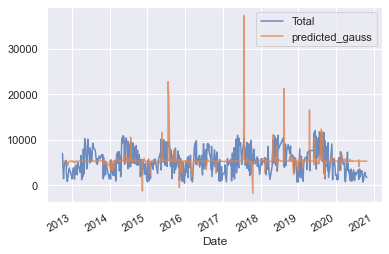

In [23]:
# Fit model
model_gauss = LinearRegression(fit_intercept=False)
model_gauss.fit(x_gauss_train, y_train_norm)

# Predict
daily_val['predicted_gauss'] = scaler_y.inverse_transform(model_gauss.predict(x_gauss_val).reshape(-1, 1)).reshape(-1)

# Plot
daily_val[['Total', 'predicted_gauss']].plot(alpha=0.8)

print(f'R^2 third degree polynomial:  {model_poly3.score(x_poly3_val, y_val):.3f}')
print(f'R^2 Gaussian RBF:             {model_gauss.score(x_gauss_val, y_val_norm):.3f}')

The approximation is much worse. The negative $R^2$ score indicated, that this model is worse than just using the average as prediction.

Looking only at the training data set

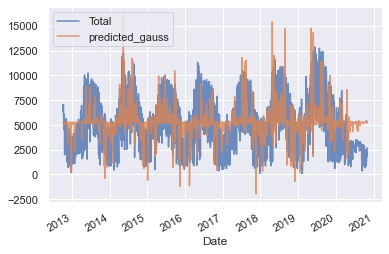

In [24]:
daily_train['predicted_gauss'] = scaler_y.inverse_transform(model_gauss.predict(x_gauss_train).reshape(-1, 1)).reshape(-1)
daily_train[['Total', 'predicted_gauss']].plot(alpha=0.8);

shows that the model massively overfits the training data.

## Regularization
Since here we can no additional data points, we use regularization to deal with overfitting.

Let's use polynomial features and Ridge Regression.

R^2 no normalization:             0.716
R^2 Ridge normalization(alpha=1): 0.726


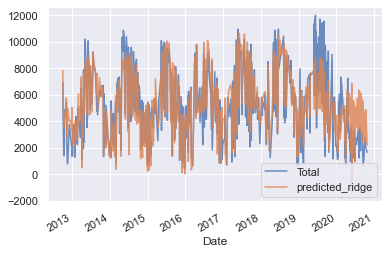

In [25]:
from sklearn.linear_model import Ridge

# Fit model
model_ridge = Ridge(alpha=0.1, fit_intercept=False)
model_ridge.fit(x_poly3_train, y_train)


# Predict
daily_val['predicted_ridge'] = model_ridge.predict(x_poly3_val)

# Plot
daily_val[['Total', 'predicted_ridge']].plot(alpha=0.8);

# Compute scores
print(f'R^2 no normalization:             {model_poly3.score(x_poly3_val, y_val):.3f}')
print(f'R^2 Ridge normalization(alpha=1): {model_ridge.score(x_poly3_val, y_val):.3f}')

Applying normalization further improves the model a little bit. However, it is not clear which value to use for alpha.

### Grid Search

We can find the optimal value for alpha via grid search.

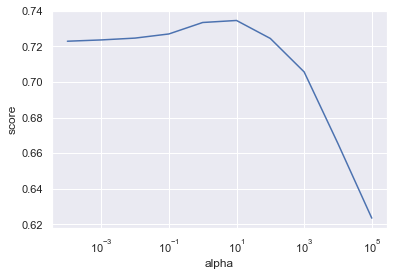

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

parameters = {'alpha': np.logspace(-4, 5, num=10)}

ps = PredefinedSplit(np.concatenate([np.repeat(-1, len(x_poly3_train)), np.repeat(0, len(x_poly3_val))])) # Use same train and test sets as before
clf = GridSearchCV(Ridge(), parameters, cv=ps)
clf.fit(np.concatenate([x_poly3_train, x_poly3_val]), np.concatenate([y_train, y_val]))

# Plot grid search result
plt.plot([d['alpha'] for d in clf.cv_results_['params']], clf.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel(r"alpha")
plt.ylabel(r"score")
plt.show()

The best score is found for alpha=10.

In [27]:
model_ridge_best = Ridge(alpha=clf.best_params_['alpha'], fit_intercept=False).fit(x_poly3_train, y_train)

print(f'R^2 Ridge normalization(alpha=1):  {model_ridge.score(x_poly3_val, y_val):.3f}')
print(f'R^2 Ridge normalization(alpha=10): {model_ridge_best.score(x_poly3_val, y_val):.3f}')

R^2 Ridge normalization(alpha=1):  0.726
R^2 Ridge normalization(alpha=10): 0.734


## Test Set

We continuously increased our score on the validation set. However, we also chose our model to exactly increase this score, so it may be biased.

In [28]:
# Transform test set

x_nd_test = daily_test[input_column_names].values
x_poly3_test = poly3.fit_transform(x_nd_test)
y_test = daily_test['Total'].values 

print(f'R^2 Ridge normalization(alpha=10): {model_ridge_best.score(x_poly3_test, y_test):.3f}')

R^2 Ridge normalization(alpha=10): 0.756


Our model does also perform well on the held out test set.